# Estimating the probability of IQ impairment from blood phenylalanine for phenylketonuria patients

The association of blood phenylalanine levels with IQ was meta-analyzed using a hierarchical mixed-effects model, estimated using Markov chain Monte Carlo methods. In an effort to partially pool the information from the set of studies obtained in the literature search, we specified random effects for the intercept and slope parameters of a linear relationship between blood Phe level and IQ. Importantly, this allowed each study to have its own parameters, each sampled from a conceptual population of parameters. Those with smaller sample sizes were automatically shrunk towards the population means for each parameter, with larger studies influencing the estimate of the population mean more than being influenced by it. In turn, the magnitude of the effect (*i.e.* slope) was specified partly as a function of a fixed effect that accounted for whether measurements of Phe were carried out during the critical period. Hence, the overall model was a hierarchical mixed effects model. Bayesian hierarchical models are easily estimated using Markov chain Monte Carlo (MCMC) methods.

## Data import and cleanup

The following entries show how data were imported and cleaned prior to being input into the model.

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
observations = pd.read_csv("kq1-2.csv", index_col=0)

In [3]:
observations.head()

,Paper ID,Group ID,N,Age,Age SD,Age low,Age high,Concurrent,Critical period,Phe,Phe SD,Phe low,Phe high,IQ scale,IQ,IQ SD,IQ low,IQ high,Correlation,p
Observation ID,,,,,,,,,,,,,,,,,,,,
1,54,1,46,7.500000,3.3,2.9,15.5,0,1,312.0,132.0,125.0,852.0,Weschler,104.0,15.0,68.0,143.0,-0.17,0.38
2,80,12,1,7.666667,NaN,NaN,NaN,1,0,704.0,NaN,NaN,NaN,Raven,91.0,NaN,NaN,NaN,NaN,NaN
3,80,13,1,6.583333,NaN,NaN,NaN,1,0,1418.0,NaN,NaN,NaN,Raven,128.0,NaN,NaN,NaN,NaN,NaN
4,80,14,1,17.083333,NaN,NaN,NaN,1,0,1402.0,NaN,NaN,NaN,Raven,112.0,NaN,NaN,NaN,NaN,NaN
5,80,15,1,12.083333,NaN,NaN,NaN,1,0,1207.0,NaN,NaN,NaN,Raven,120.0,NaN,NaN,NaN,NaN,NaN


In [4]:
HISTORICAL, CONCURRENT = 0,1

Extract historical observations only

In [5]:
observations = observations[observations.Concurrent == HISTORICAL]

Get list of set of unique papers

In [6]:
unique_papers = set(observations['Paper ID'])
unique_papers

{54, 494, 794, 1054, 1156, 1222, 1420, 1429, 1431, 1432, 1448, 2939}

Re-number papers

In [7]:
paper_lookup = dict(zip(unique_papers, range(len(unique_papers))))
paper_id = observations['Paper ID'].replace(paper_lookup)

Unique group ID numbers

In [8]:
unique_groups = set(observations['Group ID'])

In [9]:
group_lookup = dict(zip(unique_groups, range(len(unique_groups))))
group_id = observations['Group ID'].replace(group_lookup)

Individual-level data

In [10]:
indiv = observations.N == 1
obs_indiv = observations[indiv]

Group-summarized data

In [11]:
obs_summ = observations[~indiv]

Group and paper IDs for individual data

In [12]:
group_id_indiv = group_id[indiv].values
paper_id_indiv = paper_id[indiv].values

Unique paper ID's for individual studies

In [13]:
unique_papers_indiv = set(paper_id_indiv)

Group and paper IDs for summarized data

In [14]:
group_id_summ = group_id[~indiv].values
paper_id_summ = paper_id[~indiv].values

Unique paper IDs for summarized data

In [15]:
unique_papers_summ = set(paper_id_summ)

## PKU Model

We developed two meta-analytic models. The first represents the relationship of blood Phe and IQ when Phe was measured historically with respect to IQ measurement (more than 12 months before IQ measurement), while in the second model, Phe and IQ were measured concurrently (Phe measured within 6 weeks prior to IQ measurement). Note that there were no studies in which Phe measurements were taken 6 weeks to 12 months prior to IQ measurements. We believed it to be unreasonable to combine historical and concurrent measurements in the same model, given the potential for a drastically different relationship between the two variables depending on how far apart they were taken. The example below illustrates the historical measurement model.

In [16]:
import pymc3 as pm

For some studies, Phe was only reported as a range. In these cases, we can impute Phe simulaneously as we fit the rest of the model. Here, we model the missing values as uniform random variables across the reported range.

In [17]:
obs_indiv.Phe.head()

Observation ID
14    372.0
15    336.0
16    378.0
17    390.0
18    576.0
Name: Phe, dtype: float64

In [18]:
obs_indiv.Phe.isnull().sum()

12

In [19]:
phe_missing = np.ma.masked_values(obs_indiv.Phe.fillna(999).values, value=999)
phe_missing

masked_array(data = [372.0 336.0 378.0 390.0 576.0 510.0 570.0 462.0 282.0 456.0 900.0 708.0
 576.0 468.0 1170.0 726.0 1008.0 804.0 852.0 480.0 500.0 530.0 520.0 560.0
 890.0 470.0 660.0 650.0 820.0 900.0 920.0 780.0 420.0 540.0 520.0 970.0 --
 -- -- -- 1500.0 -- -- -- -- -- -- -- 1860.0 -- 880.0 810.0 660.0 230.0
 370.0 700.0 420.0 640.0 530.0 590.0 320.0 380.0 620.0 340.0 300.0 580.0
 450.0 510.0 490.0 410.0 450.0 470.0 700.0 703.0 570.0 550.0 700.0 800.0
 230.0 1420.0 1160.0 740.0 510.0 890.0 820.0 700.0 960.0 640.0 700.0 630.0
 760.0 850.0 910.0 360.0 552.0 594.0 474.0 630.0 684.0 618.0 840.0 438.0
 498.0 444.0 570.0],
             mask = [False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
  True  True  True  True False  True  True  True  True  True  True  True
 False  True False False False False False False False Fa

### Linear model

The core of each model is a linear relationship between the expected IQ ($\mu$) and Phe ($x$):

$$\mu_i = \beta_{0j[i]} + \beta_{1i} x_i$$


The subscript $j[i]$ denotes parameters for study $j$ corresponding to observation $i$. Hence, both the intercept $\beta_0$ and slope $\beta_1$ are allowed to vary by study. Note that by *observation* we refer here not to individuals, but to groups of individuals within a study that share a covariate. For example, within the same study, one group of individuals might have been measured for Phe in the critical period, and others not; these groups were considered separate observations in this analysis. One study reported a range of Phe measurements, rather than a single value, so we imputed values by randomly sampling at every iteration from a uniform distribution across the reported range.


The intercept was modeled as a random effect, where each study is assumed to be an exchangeable (\emph{i.e.} conditionally independent) sample from a population of PKU studies:

$$\beta_{0j[i]} \sim N(\mu_{\beta}, \tau_{\beta})$$

Thus, $\mu_{\beta}$ is the expected (population) mean and $\tau_{\beta}$ the associated variance, describing the expected differences within the population. This random effect was included to account for a variety of potential sources of variation in IQ, such as the IQ measurement scale in each study or geographic location.

In [37]:
with pm.Model() as pku_model:

    # Mean intercept
    μ_int = pm.Normal('μ_int', mu=100, sd=100)

    # SD of intercepts
    σ_int = pm.HalfCauchy('σ_int', 3)


    # Intecepts by study
    z_int = pm.Normal('z_int', 0, 1, shape=len(unique_papers))
    β_0 = pm.Deterministic('β_0', μ_int + z_int*σ_int)

The slope of the relationship included a study-level random effect and a fixed effect corresponding to whether the Phe measurement was taken during the critical period (via indicator function $I$):

$$
\begin{aligned}
    \beta_{1i} &= \alpha_{0i} + \alpha_1 I(\textbf{crit}_{j[i]}=1) \\
    \alpha_{0i} &= N(\mu_{\alpha},\tau_{\alpha})
\end{aligned}
$$

In [38]:
with pku_model:
    # Mean slope
    μ_slope = pm.Normal('μ_slope', mu=0, sd=10)

    # SD of slopes
    σ_slope = pm.HalfCauchy('σ_slope', 3)

    # Random slopes by study
    z_slope = pm.Normal('z_slope', 0, 1, shape=len(unique_papers))
    α_0 = pm.Deterministic('α_0', μ_slope + z_slope*σ_slope)
    α_1 = pm.Normal('α_1', mu=0, sd=10)

Calculate Phe effect (slope) for each individual

In [39]:
with pku_model:
    
    # Calculate Phe effect (slope) for each individual
    β_1_indiv = α_0[paper_id_indiv] + α_1*obs_indiv['Critical period'].values


Calculate expected IQ

(array([ 13.,  27.,  26.,  13.,  21.,   2.,   0.,   2.,   0.,   1.]),
 array([  230.,   393.,   556.,   719.,   882.,  1045.,  1208.,  1371.,
         1534.,  1697.,  1860.]),
 <a list of 10 Patch objects>)

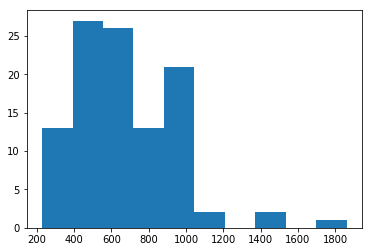

In [40]:
plt.hist(phe_missing)

In [41]:
with pku_model:
    
    # Impute missing values
    phe_imputed = pm.Uniform('phe_imputed', phe_missing.min(), phe_missing.max(), observed=phe_missing)
    
    μ_iq = β_0[paper_id_indiv] + β_1_indiv*phe_imputed


Process noise (variance of observations about predicted mean)

In [42]:
with pku_model:
    
    σ_iq = pm.HalfCauchy('σ_iq', 3)


Finally, the expected value of IQ was used to model the distribution of observed IQ values $IQ_i$, with error described by the variance $\tau$

$$IQ_i \sim N(\mu_i,\tau)$$

In [43]:
with pku_model:
    
    iq_like = pm.Normal('iq_like', mu=μ_iq, sd=σ_iq, observed=obs_indiv['IQ'].values)

### Inference from studies with summarized data

Twelve studies provided only summarized data, with no individual measurements of Phe or IQ. For studies that provided only data summaries, we were unable to directly estimate the quantities as specified above. Instead, we employed reported correlation coefficients to obtain inference regarding the relationship of these variables. Inference regarding the linear relationship (slope) between Phe and IQ can be obtained from the correlation coefficient ($\rho$), using the Fisher transformation. Here, the hyperbolic function can be used to transform the correlation to a normally-distributed random variable:

$$\text{arctanh}(r_J) \sim N \left( \text{arctanh}(\rho_j), \frac{1}{\sqrt{n_j - 3}} \right)$$
    
where $r_j$ is the reported Pearson correlation from study $j$, with a standard error that is solely a function of the corresponding sample size $n$ (for a Spearman correlation, the standard error is the inverse square root of $n-2$). This provides a measure of precision for the reported correlations, which in turn becomes a measure of precision for the slope of the relationship between Phe and IQ. The expected value of the slope was obtained in the model by converting $\rho$ using the fundamental relationship:

$$\beta_{1j} = \rho_j \left( \frac{s_{yj}}{s_{xj}} \right)$$
    
where $s_{xj}$ and $s_{yj}$ are the reported standard deviations of the Phe levels and IQs, respectively, for study $j$, the availability of which was an inclusion criteria for the selected studies.

In [44]:
stdev_phe = obs_summ['Phe SD'].values
stdev_iq = obs_summ['IQ SD'].values
mean_phe = obs_summ['Phe'].values
mean_iq = obs_summ['IQ'].values

Calculate mean of slope for summarized data

In [28]:
with pku_model:
    
    β_1_summ = α_0[paper_id_summ] + α_1*obs_summ['Critical period']


Likelihood for correlation coefficients of summarized data

In [29]:
import theano.tensor as tt

with pku_model:
    
    # Convert slope to r
    ρ = β_1_summ*stdev_phe/stdev_iq
    
    ϵ = tt.arctan(ρ) - tt.arctan(obs_summ['Correlation'])
    
    r_like = pm.Potential('r_like', pm.Normal.dist(tt.zeros(len(obs_summ['N'])), 
                                                   tau=obs_summ['N']-3).logp(ϵ).sum())


In [30]:
ϵ.tag.test_value

array([ 0.16839016,  0.43361198,  0.47873182,  0.33667482,  0.31874756,
        0.38909723,  0.31874756,  0.15572878,  0.05693839,  0.03398691])

### Caclulating the probability of IQ dropping below threhsold values

In order to evaluate the effect of particular levels of Phe on the likelihood of cognitive impairment, we chose a threshold value of IQ to bound the definition of impairment. We assume that for a standardized measure like IQ, a boundary of one standard deviation below the mean (IQ=85) was a reasonable choice. This threshold value was used to define indicator variables that were set to one if the value of the predicted IQ was below 85 during the current iteration of the MCMC sampler, and zero otherwise. Hence, for each combination of predictors, the total number of ones divided by the number of MCMC iterations represents a posterior predictive probability of observing IQ $< 85$. This corresponds to the integral of the posterior predictive distribution of IQ up to an 85 score. To illustrate the variation of this probability in response to Phe, this probability was calculated for a range of blood Phe levels from 200 to 3000 $\mu$mol/L, in increments of 200.  This was done for critical period and non-critical period Phe measurement, under both the historical and concurrent measurement models. To assess the performance of the models for a lower threshold value, we also estimated the probability of IQ lower than 70 (two standard deviations below the population mean), characterizing those with intellectual disabilities.

In [31]:
# # Ranges of predictors
# crit_pred, phe_pred = np.transpose([[crit, phe] for crit in [0,1] for phe in np.arange(200,3200, 200)])

# @deterministic(cache_depth=0)
# def pred(a1=alpha1, mu_int=mu_int, tau_int=tau_int, mu_slope=mu_slope, tau_slope=tau_slope, tau_iq=tau_iq):
#     """Estimate the probability of IQ<85 for different covariate values"""
    
#     b0 = rnormal(mu_int, tau_int, size=len(phe_pred))
#     a0 = rnormal(mu_slope, tau_slope, size=len(phe_pred))

#     b1 = a0 + a1*crit_pred

#     iq = rnormal(b0 + b1*phe_pred, tau_iq)

#     return [iq<v for v in (70,75,80,85)]

Run the model using MCMC

In [45]:
with pku_model:
    
    trace = pm.sample(1000, tune=2000, njobs=2, init='advi')

Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average Loss = 1,180.9:  94%|█████████▍| 187779/200000 [01:19<00:06, 1980.28it/s] 
Convergence archived at 187800
Interrupted at 187,799 [93%]: Average Loss = 5.77e+05
 87%|████████▋ | 2598/3000 [00:34<00:07, 51.63it/s] /Users/fonnescj/Repos/pymc3/pymc3/step_methods/hmc/nuts.py:468: UserWarning: Chain 1 contains 964 diverging samples after tuning. If increasing `target_accept` does not help try to reparameterize.
  % (self._chain_id, n_diverging))
100%|█████████▉| 2998/3000 [00:40<00:00, 46.14it/s]/Users/fonnescj/Repos/pymc3/pymc3/step_methods/hmc/nuts.py:468: UserWarning: Chain 0 contains 987 diverging samples after tuning. If increasing `target_accept` does not help try to reparameterize.
  % (self._chain_id, n_diverging))
100%|██████████| 3000/3000 [00:40<00:00, 74.00it/s]


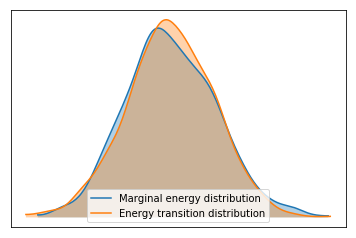

In [46]:
pm.energyplot(trace)

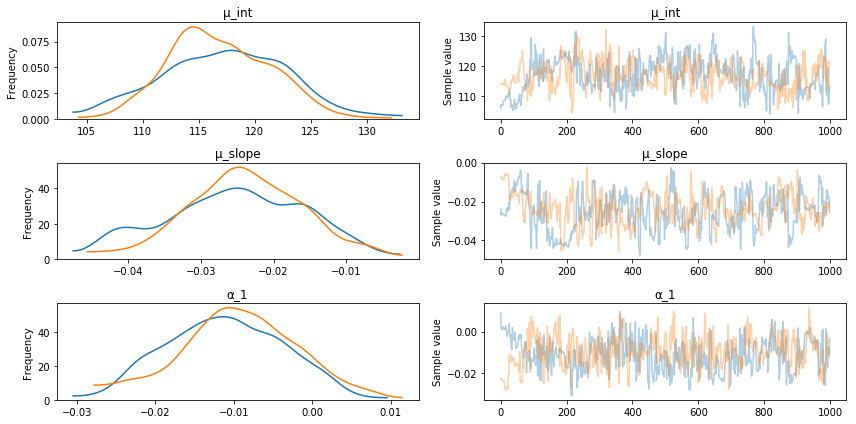

In [49]:
pm.traceplot(trace, ['μ_int', 'μ_slope', 'α_1']);

Visualization of the estimated probabilities of IQ less than either 85 (darker lines) or 75 (lighter lines) as a function of historical Phe measurement.

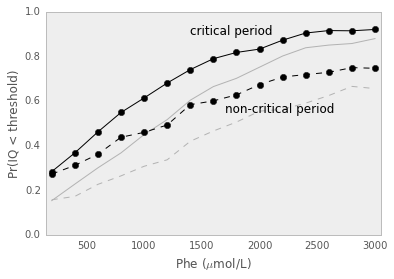

In [36]:
%matplotlib inline
import matplotlib.pyplot as plt

historical = np.sum(M.trace("pred")[:], 0)/float(iterations-burn)

x = np.arange(200,3200, 200)

colors = ('0.7', 'black')
markers = (False, True)

for i,p in enumerate((70,85)):
    plt.plot(x, historical[i*-1][M.crit_pred==1], color=colors[i], marker='o'*markers[i])
    plt.plot(x, historical[i*-1][M.crit_pred==0], color=colors[i], marker='o'*markers[i], linestyle="dashed")
plt.xlim(150, 3050)
plt.ylim(0,1)

plt.xlabel("Phe ($\mu$mol/L)")
plt.ylabel("Pr(IQ < threshold)")
plt.text(1400, 0.9, "critical period", fontsize=12)
plt.text(1700, 0.55, "non-critical period", fontsize=12)